In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import scipy.stats as st
from scipy.stats import t
import matplotlib.pyplot as plt
# import scipy.stats as stats

In [4]:
models = './models/'
models_res_all = pd.read_csv(f'{models}All channels models results.csv')
columns = models_res_all.columns .tolist()
print(f'Number of all models: {models_res_all.shape[0]}')
models_res = models_res_all.copy()

Number of all models: 36


In [5]:
models_res_all.columns

Index(['Model', 'Image size', 'Batch Size', '3Ch CV score', '3Ch PrLB score',
       '3Ch PubLB score', 'EI 4Ch CV channels', 'EI 4Ch Private LB',
       'EI 4Ch Public LB', 'MI 4Ch CV', 'MI 4Ch Private LB',
       'MI 4Ch Public LB', 'CV 5 channels', 'Private LB 5 ch',
       'Public LB 5 ch', 'Remarks'],
      dtype='object')

In [6]:
models_res_all['mean_AUC'] = models_res_all[['3Ch CV score', '3Ch PrLB score',
       '3Ch PubLB score', 'EI 4Ch CV channels', 'EI 4Ch Private LB',
       'EI 4Ch Public LB', 'MI 4Ch CV', 'MI 4Ch Private LB',
       'MI 4Ch Public LB', 'CV 5 channels']].mean(axis = 1, skipna = True)

In [7]:
models_res_all.head()

,Model,Image size,Batch Size,3Ch CV score,3Ch PrLB score,3Ch PubLB score,EI 4Ch CV channels,EI 4Ch Private LB,EI 4Ch Public LB,MI 4Ch CV,MI 4Ch Private LB,MI 4Ch Public LB,CV 5 channels,Private LB 5 ch,Public LB 5 ch,Remarks,mean_AUC
0,EfficientNet B0 v2,128,128,0.8310,0.8111,0.8278,NaN,NaN,NaN,0.8290,0.8115,0.8339,0.8410,0.8260,0.8398,RGB - MI - EI,0.826471
1,EfficientNet B0 v2,128,128,0.8448,0.8209,0.8116,NaN,NaN,NaN,0.8338,0.8161,0.8405,0.8347,0.8203,0.8350,RGB - MI - EI,0.828914
2,EfficientNet B0 v2,256,64,0.8543,0.8352,0.8538,NaN,NaN,NaN,0.8544,0.8423,0.8677,0.8613,0.8643,0.8596,RGB - MI - EI,0.852714
3,EfficientNet B0 v2,512,64,0.8609,0.8569,0.8640,NaN,NaN,NaN,0.8588,0.8449,0.8582,0.8599,0.8582,0.8698,RGB - MI - EI,0.857657
4,EfficientNet B0 v2,512,64,0.8792,0.8667,0.8729,NaN,NaN,NaN,0.8698,0.8678,0.8745,0.8928,0.8699,0.8747,RGB - MI - EI,0.874814


In [8]:
models_res_all[['Image size', 'Batch Size', 'mean_AUC']].corr(method='pearson')

,Image size,Batch Size,mean_AUC
Image size,1.000000,-0.553547,0.562416
Batch Size,-0.553547,1.000000,-0.584383
mean_AUC,0.562416,-0.584383,1.000000


In [9]:
models_res_all[['Image size', 'Batch Size', 'mean_AUC']].corr(method='kendall')

,Image size,Batch Size,mean_AUC
Image size,1.000000,-0.548939,0.436350
Batch Size,-0.548939,1.000000,-0.293045
mean_AUC,0.436350,-0.293045,1.000000


In [10]:
models_res_all[['Image size', 'Batch Size', 'mean_AUC']].corr(method='spearman')

,Image size,Batch Size,mean_AUC
Image size,1.000000,-0.58892,0.521806
Batch Size,-0.588920,1.00000,-0.394110
mean_AUC,0.521806,-0.39411,1.000000


In [11]:
bs = models_res_all[['Batch Size', 'mean_AUC']]
ims = models_res_all[['Image size', 'mean_AUC']]


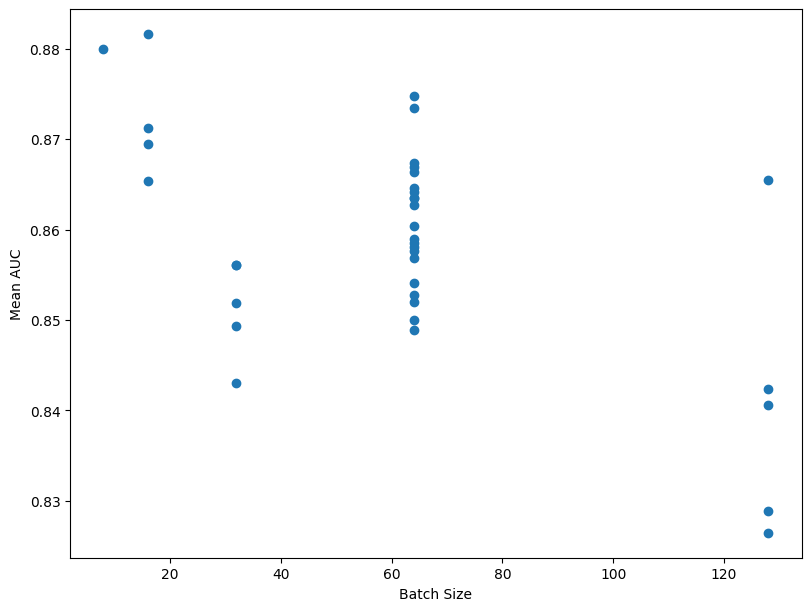

In [12]:
fig, ax = plt.subplots(layout='constrained', figsize=(8, 6))
plt.scatter(models_res_all['Batch Size'], models_res_all['mean_AUC'])
# ax.legend(loc = 'upper left', ncols = 2)
plt.xlabel('Batch Size')
plt.ylabel('Mean AUC')
# plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using Private LB only - 3 channels vs 4 channels with {ch4} images')
plt.show()

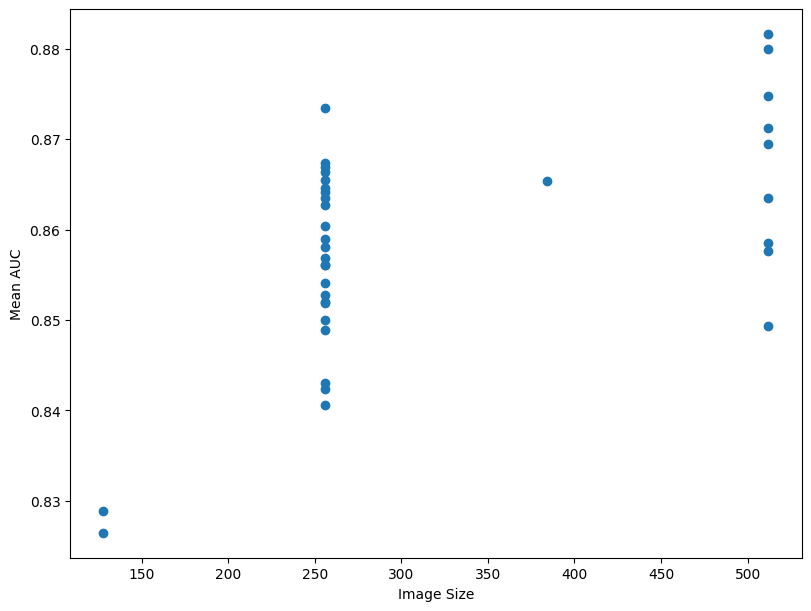

In [13]:
fig, ax = plt.subplots(layout='constrained', figsize=(8, 6))
plt.scatter(models_res_all['Image size'], models_res_all['mean_AUC'])
# ax.legend(loc = 'upper left', ncols = 2)
plt.xlabel('Image Size')
plt.ylabel('Mean AUC')
# plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using Private LB only - 3 channels vs 4 channels with {ch4} images')
plt.show()

Lets separate models using EI index as the 4th channel from the ones using MI index.<br>
We will run the t-test on these subsets separately. 

In [14]:
models_res_EI = models_res_all.loc[models_res_all['EI 4Ch CV channels'] > 0]
print(f'Number of the models with EI index: {models_res_EI.shape[0]}')

Number of the models with EI index: 31


In [15]:
models_res_MI = models_res_all.loc[models_res_all['MI 4Ch CV'] > 0]
print(f'Number of the models with MI index: {models_res_MI.shape[0]}')

Number of the models with MI index: 17


In [16]:
def interpret(tstat, p, cv, alpha = 0.05):   
    # interpret via critical value
    score = 0
    if abs(tstat) <= cv:
        print(f'Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value {cv:.4f}.')
    else:
        score += 1
    if p > alpha:
        print(f'Accept the null hypothesis, because p value is bigger than the alpha = {alpha}.')
    else:
        score += 1
    if score == 2:
        print('Reject the null hypothesis.\n')
    else:
        print('\n')
        

In [17]:
def t_decision(models_res, ch4 = 'EI'):
    print('Null hypothesis is that the means are indistinguishable. \n')
    CV_3_channels = models_res['3Ch CV score'].dropna().values
    CV_EI4_channels = models_res['EI 4Ch CV channels'].dropna().values
    CV_MI4_channels = models_res['MI 4Ch CV'].dropna().values
    CV_5_channels = models_res_all['CV 5 channels'].dropna().values
#     CV_5_channels = models_res['CV 5 channels'].dropna().values

    Pub_3_channels = models_res['3Ch PubLB score'].dropna().values
    Pub_EI4_channels  = models_res['EI 4Ch Public LB'].dropna().values
    Pub_MI4_channels  = models_res['MI 4Ch Public LB'].dropna().values
    Pub_5_channels = models_res_all['Public LB 5 ch'].dropna().values
#     Pub_5_channels = models_res['Public LB 5 ch'].dropna().values
    
    Prv_3_channels = models_res['3Ch PrLB score'].dropna().values
    Prv_EI4_channels  = models_res['EI 4Ch Private LB'].dropna().values
    Prv_MI4_channels  = models_res['MI 4Ch Private LB'].dropna().values
    Prv_5_channels = models_res_all['Private LB 5 ch'].dropna().values
#     Prv_5_channels = models_res['Private LB 5 ch'].dropna().values
       
    print(f"Number of the data points for Cross-Validation (CV) dataset only: {len(CV_3_channels)}")
    
    n3    = len(CV_3_channels)
    n4_EI = len(CV_EI4_channels)
    n4_MI = len(CV_MI4_channels)
    n5    = len(CV_5_channels)
    print('Means:')
    print(f'3 channels: {CV_3_channels.mean():.4f}')
    print(f'4 channels with EI: {CV_EI4_channels.mean():.4f}')
    print(f'4 channels with MI: {CV_MI4_channels.mean():.4f}')
    print(f'5 channels: {CV_5_channels.mean():.4f}')
    
    alpha = 0.05
                                   
    print('The Levene test tests the null hypothesis that all input samples are from populations with equal variances.')
    print(f"{stats.levene(CV_3_channels, CV_EI4_channels, CV_5_channels, center = 'mean')}")
    if ch4 == 'EI':
        # degrees of freedom
        df = n3 + n4_EI - 2
        # calculate the critical value
        cv = t.ppf(1.0 - alpha, df)
        print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    
        t_lev, p_lev = stats.levene(CV_3_channels, CV_EI4_channels, center = 'mean')
        if p_lev <= alpha: 
            res = 'similar' 
        else: 
            res = 'diffrent'
        print(f"Levene test p-value = {p_lev}, the variance is {res} in these datasets")
        tstat_4, p4 = stats.ttest_ind(CV_3_channels, CV_EI4_channels)
        print(f"4 channels with EI vs 3 channeles t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
        interpret(tstat_4, p4, cv, alpha = 0.05)
    else:
        # degrees of freedom
        df = n3 + n4_MI - 2
        # calculate the critical value
        cv = t.ppf(1.0 - alpha, df)
        print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    
        t_lev, p_lev = stats.levene(CV_3_channels, CV_MI4_channels, center = 'mean')
        if p_lev <= alpha: 
            res = 'similar' 
        else: 
            res = 'diffrent'
        print(f"Levene test p-value = {p_lev}, the variance is {res} in these datasets")
        tstat_4, p4 = stats.ttest_ind(CV_3_channels, CV_MI4_channels)
        print(f"4 channels with MI vs 3 channeles t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
        print(f"Levene test = {stats.levene(CV_3_channels, CV_MI4_channels, center = 'mean')}")
        interpret(tstat_4, p4, cv, alpha = 0.05)
                                   
    t_lev, p_lev = stats.levene(CV_3_channels, CV_5_channels, center = 'mean')
    result = stats.levene(CV_3_channels, CV_5_channels, center = 'median')
    if p_lev <= alpha: 
        res = 'similar' 
    else: 
        res = 'diffrent'
    print(f"Levene test p-value = {p_lev}, the variance is {res} in these datasets")
    print(f'{result}')
    tstat_5, p5 = stats.ttest_ind(CV_3_channels, CV_5_channels)
    print(f"5 channels vs 3 channeles t-statistic = {tstat_5:.2f}, p value = {p5:.4f}")
#     print(f"Levene test = {stats.levene(CV_3_channels, CV_5_channels, center = 'mean')}")
    interpret(tstat_5, p5, cv, alpha = 0.05)
    
    CV_scores_all_3 = np.concatenate((CV_3_channels, Pub_3_channels, Prv_3_channels))
    CV_scores_all_5 = np.concatenate((CV_5_channels, Pub_5_channels, Prv_5_channels))
    if ch4 == 'EI':
        CV_scores_all_4 = np.concatenate((CV_EI4_channels, Pub_EI4_channels, Prv_EI4_channels))
    else:
        CV_scores_all_4 = np.concatenate((CV_MI4_channels, Pub_MI4_channels, Prv_MI4_channels))
    
    print(f"Number of the data points in the combined CV + PrivateLB + PublicLB dataset: {len(CV_scores_all_3)}")

    n3 = len(CV_scores_all_3)
    n4 = len(CV_scores_all_4)
    n5 = len(CV_scores_all_5)

    print('Means:')
    print(f'3 channels: {CV_scores_all_3.mean():.4f}')
    print(f'4 channels with {ch4}: {CV_scores_all_4.mean():.4f}')
    print(f'5 channels: {CV_scores_all_5.mean():.4f}')

    # degrees of freedom
    df = n3 + n4 - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    
    tstat_4, p4 = stats.ttest_ind(CV_scores_all_3, CV_scores_all_4)
    print(f"4 channels with {ch4} vs 3 channeles t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
    print(f"Levene test = {stats.levene(CV_scores_all_3, CV_scores_all_4, center = 'mean')}")
    interpret(tstat_4, p4, cv, alpha = alpha)

    tstat_5, p5 = stats.ttest_ind(CV_scores_all_3, CV_scores_all_5)
    print(f"5 channels vs 3 channeles t-statistic = {tstat_5:.2f}, p value = {p5:.4f}")
    print(f"Levene test = {stats.levene(CV_scores_all_3, CV_scores_all_5, center = 'mean')}")
    interpret(tstat_5, p5, cv, alpha = alpha)
  

Null hypothesis is that the means are indistinguishable. 

Number of the data points for Cross-Validation (CV) dataset only: 31
Degrees of freedom = 60, Critical Value = 1.6706 



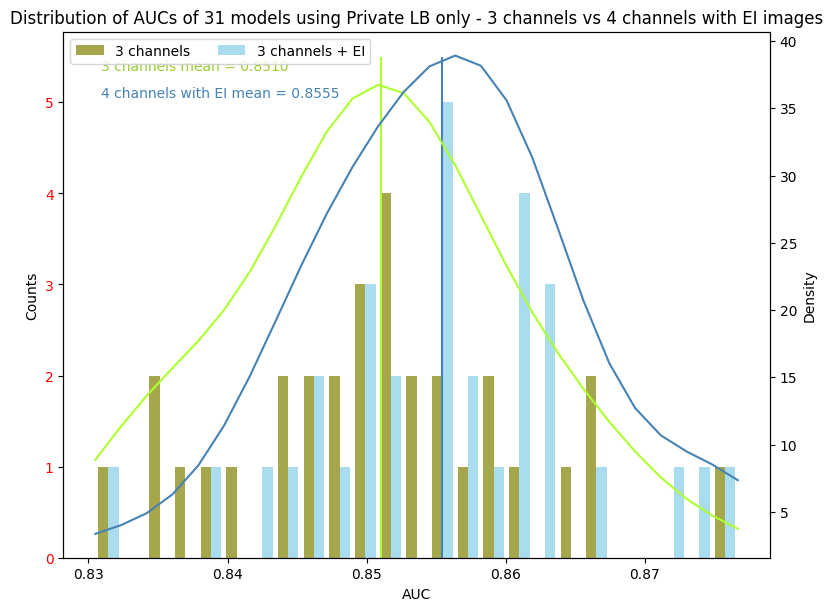

In [21]:
models_res = models_res_EI
ch4 = 'EI'
print('Null hypothesis is that the means are indistinguishable. \n')
CV_3_channels = models_res['3Ch CV score'].dropna().values
CV_3_channels_all = models_res_all['3Ch CV score'].dropna().values
CV_EI4_channels = models_res['EI 4Ch CV channels'].dropna().values
CV_MI4_channels = models_res['MI 4Ch CV'].dropna().values
CV_5_channels = models_res_all['CV 5 channels'].dropna().values
#     CV_5_channels = models_res['CV 5 channels'].dropna().values

Pub_3_channels = models_res['3Ch PubLB score'].dropna().values
Pub_3_channels_all = models_res_all['3Ch PubLB score'].dropna().values
Pub_EI4_channels  = models_res['EI 4Ch Public LB'].dropna().values
Pub_MI4_channels  = models_res['MI 4Ch Public LB'].dropna().values
Pub_5_channels = models_res_all['Public LB 5 ch'].dropna().values
#     Pub_5_channels = models_res['Public LB 5 ch'].dropna().values

Prv_3_channels = models_res['3Ch PrLB score'].dropna().values
Prv_3_channels_all = models_res_all['3Ch PrLB score'].dropna().values
Prv_EI4_channels  = models_res['EI 4Ch Private LB'].dropna().values
Prv_MI4_channels  = models_res['MI 4Ch Private LB'].dropna().values
Prv_5_channels = models_res_all['Private LB 5 ch'].dropna().values
#     Prv_5_channels = models_res['Private LB 5 ch'].dropna().values

labels4 = ['3 channels', f'3 channels + {ch4}']
labels5 = ['3 channels', '5 channels']
labels_all = ['3 channels', f'3 channels + {ch4}', '5 channels']
alpha = 0.05
n_bins = 25

print(f"Number of the data points for Cross-Validation (CV) dataset only: {len(CV_3_channels)}")

n3    = len(Prv_3_channels)
n4_EI = len(Prv_EI4_channels)
n4_MI = len(Prv_MI4_channels)
n5    = len(Prv_5_channels)

if ch4 == 'EI':
    # degrees of freedom
    df = n3 + n4_EI - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    Prv_4_channels = Prv_EI4_channels
else:
    df = n3 + n4_MI - 2
    cv = t.ppf(1.0 - alpha, df)
    print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
    Prv_4_channels = Prv_MI4_channels

CV3_mean = Prv_3_channels.mean()
CV4_mean = Prv_4_channels.mean()
CV5_mean = Prv_5_channels.mean()
CV3_min = Prv_3_channels.min()
CV4_min = Prv_4_channels.min()
CV5_min = Prv_5_channels.min()

colors = ['olive', 'skyblue']

x = np.array([Prv_3_channels, Prv_4_channels]).T
fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
density_3 = st.gaussian_kde(Prv_3_channels)
density_4 = st.gaussian_kde(Prv_4_channels)
counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels4, alpha = 0.7)
ax1.tick_params(axis='y', labelcolor = 'red')
# ax1.tick_params(axis='y', labelcolor=color)
ax1.vlines(CV3_mean, 0, counts.max() + 0.5, colors = ['greenyellow'])
ax1.vlines(CV4_mean, 0, counts.max() + 0.5, colors = ['steelblue'])
ax1.text(0.05, 0.9, f'3 channels mean = {CV3_mean:.4f}', transform=ax.transAxes, color = 'yellowgreen')
ax1.text(0.05, 0.85, f'4 channels with {ch4} mean = {CV4_mean:.4f}', transform=ax.transAxes, color = 'steelblue', zorder = 2)
ax1.legend(loc = 'upper left', ncols = 2)
ax1.set_xlabel('AUC')
ax1.set_ylabel('Counts')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(bins, density_3(bins), color = 'greenyellow')
ax2.plot(bins, density_4(bins), color = 'steelblue')
ax2.set_ylabel('Density')

plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using Private LB only - 3 channels vs 4 channels with {ch4} images')
plt.show()



In [32]:
def plot(models_res, ch4 = 'EI'):
    print('Null hypothesis is that the means are indistinguishable. \n')
    CV_3_channels = models_res['3Ch CV score'].dropna().values
#     CV_3_channels_all = models_res_all['3Ch CV score'].dropna().values
    CV_EI4_channels = models_res['EI 4Ch CV channels'].dropna().values
    CV_MI4_channels = models_res['MI 4Ch CV'].dropna().values
#     CV_5_channels = models_res_all['CV 5 channels'].dropna().values
    CV_5_channels = models_res['CV 5 channels'].dropna().values

    Pub_3_channels = models_res['3Ch PubLB score'].dropna().values
#     Pub_3_channels_all = models_res_all['3Ch PubLB score'].dropna().values
    Pub_EI4_channels  = models_res['EI 4Ch Public LB'].dropna().values
    Pub_MI4_channels  = models_res['MI 4Ch Public LB'].dropna().values
#     Pub_5_channels = models_res_all['Public LB 5 ch'].dropna().values
    Pub_5_channels = models_res['Public LB 5 ch'].dropna().values
    
    Prv_3_channels = models_res['3Ch PrLB score'].dropna().values
#     Prv_3_channels_all = models_res_all['3Ch PrLB score'].dropna().values
    Prv_EI4_channels  = models_res['EI 4Ch Private LB'].dropna().values
    Prv_MI4_channels  = models_res['MI 4Ch Private LB'].dropna().values
#     Prv_5_channels = models_res_all['Private LB 5 ch'].dropna().values
    Prv_5_channels = models_res['Private LB 5 ch'].dropna().values

    labels4 = ['3 channels', f'3 channels + {ch4}']
    labels5 = ['3 channels', '5 channels']
    labels_all = ['3 channels', f'3 channels + {ch4}', '5 channels']
    alpha = 0.05
    n_bins = 25
    
    print(f"Number of the data points for Cross-Validation (CV) dataset only: {len(CV_3_channels)}")
    
    n3    = len(Prv_3_channels)
    n4_EI = len(Prv_EI4_channels)
    n4_MI = len(Prv_MI4_channels)
    n5    = len(Prv_5_channels)
                                   
    if ch4 == 'EI':
        # degrees of freedom
        df = n3 + n4_EI - 2
        # calculate the critical value
        cv = t.ppf(1.0 - alpha, df)
        print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
        Prv_4_channels = Prv_EI4_channels
    else:
        df = n3 + n4_MI - 2
        cv = t.ppf(1.0 - alpha, df)
        print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
        Prv_4_channels = Prv_MI4_channels

    CV3_mean = Prv_3_channels.mean()
    CV4_mean = Prv_4_channels.mean()
    CV5_mean = Prv_5_channels.mean()
    CV3_min = Prv_3_channels.min()
    CV4_min = Prv_4_channels.min()
    CV5_min = Prv_5_channels.min()

    colors = ['olive', 'skyblue']
        
    n3    = len(CV_3_channels)
#     n3_all    = len(CV_3_channels_all)
    n4_EI = len(CV_EI4_channels)
    n4_MI = len(CV_MI4_channels)
    n5    = len(CV_5_channels)
                                   
    if ch4 == 'EI':
        # degrees of freedom
        df = n3 + n4_EI - 2
        # calculate the critical value
        cv = t.ppf(1.0 - alpha, df)
        print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
        CV_4_channels = CV_EI4_channels
    else:
        df = n3 + n4_MI - 2
        cv = t.ppf(1.0 - alpha, df)
        print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')
        CV_4_channels = CV_MI4_channels

    CV3_mean = CV_3_channels.mean()
#     CV3_mean_all = CV_3_channels_all.mean()
    CV4_mean = CV_4_channels.mean()
    CV5_mean = CV_5_channels.mean()
    CV3_min = CV_3_channels.min()
    CV4_min = CV_4_channels.min()
    CV5_min = CV_5_channels.min()

    x = np.array([CV_3_channels, CV_4_channels]).T
    fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
    density_3 = st.gaussian_kde(CV_3_channels)
    density_4 = st.gaussian_kde(CV_4_channels)
    counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels4, alpha = 0.7)
    ax1.tick_params(axis='y', labelcolor = 'red')
    ax1.vlines(CV3_mean, 0, counts.max() + 0.5, colors = ['greenyellow'])
    ax1.vlines(CV4_mean, 0, counts.max() + 0.5, colors = ['steelblue'])
    ax1.text(0.05, 0.9, f'3 channels mean = {CV3_mean:.4f}', transform=ax1.transAxes, color = 'yellowgreen')
    ax1.text(0.05, 0.85, f'4 channels with {ch4} mean = {CV4_mean:.4f}', transform=ax1.transAxes, color = 'steelblue', zorder = 2)
    ax1.legend(loc = 'upper left', ncols = 2)
    ax1.set_xlabel('AUC')
    ax1.set_ylabel('Counts')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(bins, density_3(bins), color = 'greenyellow')
    ax2.plot(bins, density_4(bins), color = 'steelblue')
    ax2.set_ylabel('Density')
    plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using CV only - 3 channels vs 4 channels with {ch4} images')
    plt.show()
    
    tstat_4, p4 = stats.ttest_ind(CV_3_channels, CV_4_channels)
    print(f"4 channels with {ch4} vs 3 channeles t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
    interpret(tstat_4, p4, cv, alpha = 0.05)
                                      
    x = np.array([CV_3_channels, CV_5_channels]).T
    fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
    density_3 = st.gaussian_kde(CV_3_channels)
    density_5 = st.gaussian_kde(CV_5_channels)
    counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels4, alpha = 0.7)
    ax1.tick_params(axis='y', labelcolor = 'red')
    ax1.vlines(CV3_mean, 0, counts.max() + 0.5, colors = ['greenyellow'])
    ax1.vlines(CV5_mean, 0, counts.max() + 0.5, colors = ['steelblue'])
    ax1.text(0.05, 0.9, f'3 channels mean = {CV3_mean:.4f}', transform=ax1.transAxes, color = 'yellowgreen')
    ax1.text(0.05, 0.85, f'5 channels mean = {CV5_mean:.4f}', transform=ax1.transAxes, color = 'steelblue', zorder = 2)
    ax1.legend(loc = 'upper left', ncols = 2)
    ax1.set_xlabel('AUC')
    ax1.set_ylabel('Counts')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(bins, density_3(bins), color = 'greenyellow')
    ax2.plot(bins, density_5(bins), color = 'steelblue')
    ax2.set_ylabel('Density')
    plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using 3 channels vs 5 channels images')
    plt.show()    
    
    tstat_5, p5 = stats.ttest_ind(CV_3_channels, CV_5_channels)
    print(f"5 channels vs 3 channeles t-statistic = {tstat_5:.2f}, p value = {p5:.4f}")
    interpret(tstat_5, p5, cv, alpha = 0.05)

    #     all 3 together
    colors = ['coral', 'olive', 'skyblue']
    fig, ax = plt.subplots(layout='constrained', figsize=(8, 6))
    x = np.array([CV_3_channels, CV_4_channels, CV_5_channels]).T
    counts, bins, _ = plt.hist(x, n_bins, density = True,
                     histtype ='bar',  color = colors, label = labels_all, alpha = 0.7)
    plt.vlines(CV3_mean, 0, counts.max() + 1, colors = ['orangered'])
    plt.vlines(CV4_mean, 0, counts.max() + 1, colors = ['greenyellow'])
    plt.vlines(CV5_mean, 0, counts.max() + 1, colors = ['steelblue'])
    ax.text(min(CV3_min, CV5_min), counts.max() - 1, f'3 channels mean = {CV3_mean:.4f}', color = 'orangered')
    ax.text(min(CV3_min, CV5_min), counts.max() - 2, f'4 channels mean = {CV4_mean:.4f}', color = 'greenyellow')
    ax.text(min(CV3_min, CV5_min), counts.max() - 3, f'5 channels mean = {CV5_mean:.4f}', color = 'steelblue')
    ax.legend(loc = 'upper left', ncols = 3)
    plt.xlabel('AUC')
    plt.ylabel('Counts')
    plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using 3 channels vs 4 and 5 channels images')
    plt.show()


    
    
    #  combine all 3 test datasets    
    CV_scores_all_3 = np.concatenate((CV_3_channels, Pub_3_channels, Prv_3_channels))
#     CV_scores_all_3_all = np.concatenate((CV_3_channels_all, Pub_3_channels_all, Prv_3_channels_all))
    CV_scores_all_5 = np.concatenate((CV_5_channels, Pub_5_channels, Prv_5_channels))
    if ch4 == 'EI':
        CV_scores_all_4 = np.concatenate((CV_EI4_channels, Pub_EI4_channels, Prv_EI4_channels))
    else:
        CV_scores_all_4 = np.concatenate((CV_MI4_channels, Pub_MI4_channels, Prv_MI4_channels))
    
    print(f"Number of the data points in the combined CV + PrivateLB + PublicLB dataset: {len(CV_scores_all_3)}")

    n3 = len(CV_scores_all_3)
#     n3_all = len(CV_scores_all_3_all)
    n4 = len(CV_scores_all_4)
    n5 = len(CV_scores_all_5)

    # degrees of freedom
    df = n3 + n4 - 2
    # calculate the critical value
    cv = t.ppf(1.0 - alpha, df)
    print(f'Degrees of freedom = {df}, Critical Value = {cv:.4f} \n')   

    CV3_mean = CV_scores_all_3.mean()
#     CV3_mean_all = CV_scores_all_3_all.mean()
    CV4_mean = CV_scores_all_4.mean()
    CV5_mean = CV_scores_all_5.mean()
    CV3_min = CV_scores_all_3.min()
    CV4_min = CV_scores_all_4.min()
    CV5_min = CV_scores_all_5.min()
    colors = ['coral', 'forestgreen']
    

    x = np.array([CV_scores_all_3, CV_scores_all_4]).T
    fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
    density_3 = st.gaussian_kde(CV_scores_all_3)
    density_4 = st.gaussian_kde(CV_scores_all_4)
    counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels4, alpha = 0.7)
    ax1.tick_params(axis='y', labelcolor = 'red')
#     ax1.tick_params(axis='y', labelcolor=color)
    ax1.vlines(CV3_mean, 0, counts.max() + 0.5, colors = ['orangered'])
    ax1.vlines(CV4_mean, 0, counts.max() + 0.5, colors = ['darkgreen'])
    ax1.text(0.05, 0.9, f'3 channels mean = {CV3_mean:.4f}', transform=ax1.transAxes, color = 'orangered')
    ax1.text(0.05, 0.85, f'4 channels with {ch4} mean = {CV4_mean:.4f}', transform=ax1.transAxes, color = 'darkgreen', zorder = 2)
    ax1.legend(loc = 'upper left', ncols = 2)
    ax1.set_xlabel('AUC')
    ax1.set_ylabel('Counts')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(bins, density_3(bins), color = 'orangered')
    ax2.plot(bins, density_4(bins), color = 'darkgreen')
    ax2.set_ylabel('Density')
    plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using CV + PrivateLB + PublicLB test dataset - 3 channels vs 4 channels with {ch4} images')
    plt.show()   
    
    tstat_4, p4 = stats.ttest_ind(CV_scores_all_3, CV_scores_all_4)
    print(f"4 channels with {ch4} vs 3 channeles t-statistic = {tstat_4:.2f}, p value = {p4:.4f}")
    interpret(tstat_4, p4, cv, alpha = alpha)


    x = np.array([CV_scores_all_3, CV_scores_all_5]).T
    fig, ax1 = plt.subplots(layout='constrained', figsize=(8, 6))
    density_3 = st.gaussian_kde(CV_scores_all_3)
    density_5 = st.gaussian_kde(CV_scores_all_5)
    counts, bins, _ = ax1.hist(x, n_bins, density = False, histtype ='bar', color = colors, label = labels4, alpha = 0.7)
    ax1.tick_params(axis='y', labelcolor = 'red')
    ax1.vlines(CV3_mean, 0, counts.max() + 0.5, colors = ['orangered'])
    ax1.vlines(CV5_mean, 0, counts.max() + 0.5, colors = ['darkgreen'])
    ax1.text(0.05, 0.9, f'3 channels mean = {CV3_mean:.4f}', transform=ax1.transAxes, color = 'orangered')
    ax1.text(0.05, 0.85, f'5 channels mean = {CV5_mean:.4f}', transform=ax1.transAxes, color = 'darkgreen', zorder = 2)
    ax1.legend(loc = 'upper left', ncols = 2)
    ax1.set_xlabel('AUC')
    ax1.set_ylabel('Counts')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.plot(bins, density_3(bins), color = 'orangered')
    ax2.plot(bins, density_5(bins), color = 'darkgreen')
    ax2.set_ylabel('Density')
    plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using CV + PrivateLB + PublicLB test dataset - 3 channels vs 5 channels with {ch4} images')
    plt.show()   
    
    
#     tstat_5, p5 = stats.ttest_ind(CV_scores_all_3_all, CV_scores_all_5)
    tstat_5, p5 = stats.ttest_ind(CV_scores_all_3, CV_scores_all_5)
    print(f"5 channels vs 3 channeles t-statistic = {tstat_5:.2f}, p value = {p5:.4f}")
    interpret(tstat_5, p5, cv, alpha = alpha)

#     all 3 together
    colors = ['coral', 'olive', 'skyblue']
    fig, ax = plt.subplots(layout='constrained', figsize=(8, 6))
    x = np.array([CV_scores_all_3, CV_scores_all_4, CV_scores_all_5]).T
    counts, bins, _ = plt.hist(x, n_bins, density = False,
                     histtype ='bar',  color = colors, label = labels_all, alpha = 0.7)
    plt.vlines(CV3_mean, 0, counts.max() + 1, colors = ['orangered'])
    plt.vlines(CV4_mean, 0, counts.max() + 1, colors = ['darkgreen'])
    plt.vlines(CV5_mean, 0, counts.max() + 1, colors = ['steelblue'])
    ax.text(min(CV3_min, CV5_min), counts.max() - 1, f'3 channels mean = {CV3_mean:.4f}', color = 'orangered')
    ax.text(min(CV3_min, CV5_min), counts.max() - 2, f'4 channels mean = {CV4_mean:.4f}', color = 'darkgreen')
    ax.text(min(CV3_min, CV5_min), counts.max() - 3, f'5 channels mean = {CV5_mean:.4f}', color = 'steelblue')
    ax.legend(loc = 'upper left', ncols = 3)
    plt.xlabel('AUC')
    plt.ylabel('Counts')
    plt.title(f'Distribution of AUCs of {models_res.shape[0]} models using 3 channels vs 4 and 5 channels images')
    plt.show()


Null hypothesis is that the means are indistinguishable. 

Number of the data points for Cross-Validation (CV) dataset only: 31
Degrees of freedom = 60, Critical Value = 1.6706 

Degrees of freedom = 60, Critical Value = 1.6706 



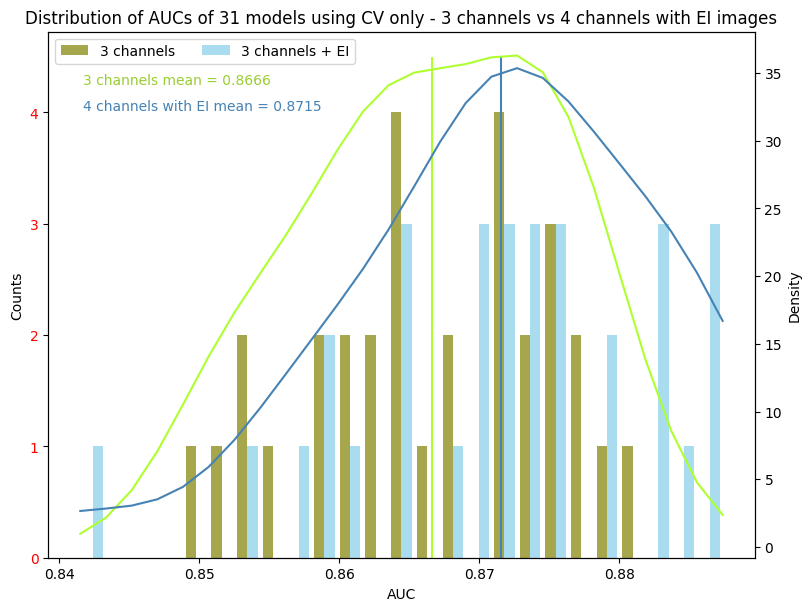

4 channels with EI vs 3 channeles t-statistic = -1.99, p value = 0.0516
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




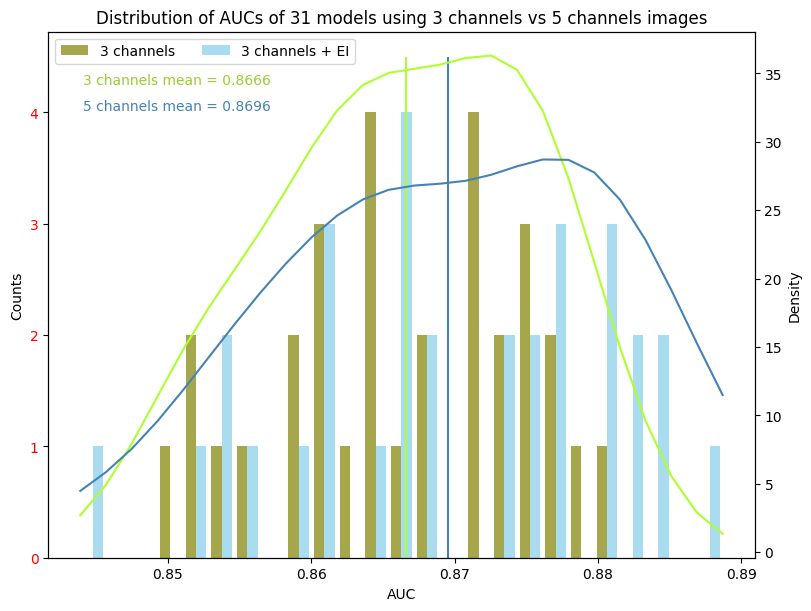

5 channels vs 3 channeles t-statistic = -1.15, p value = 0.2533
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6706.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




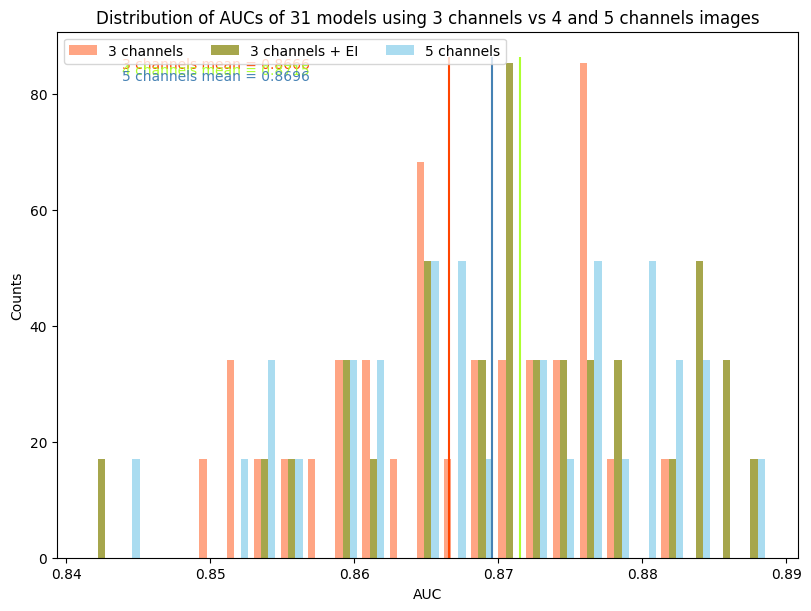

Number of the data points in the combined CV + PrivateLB + PublicLB dataset: 93
Degrees of freedom = 184, Critical Value = 1.6532 



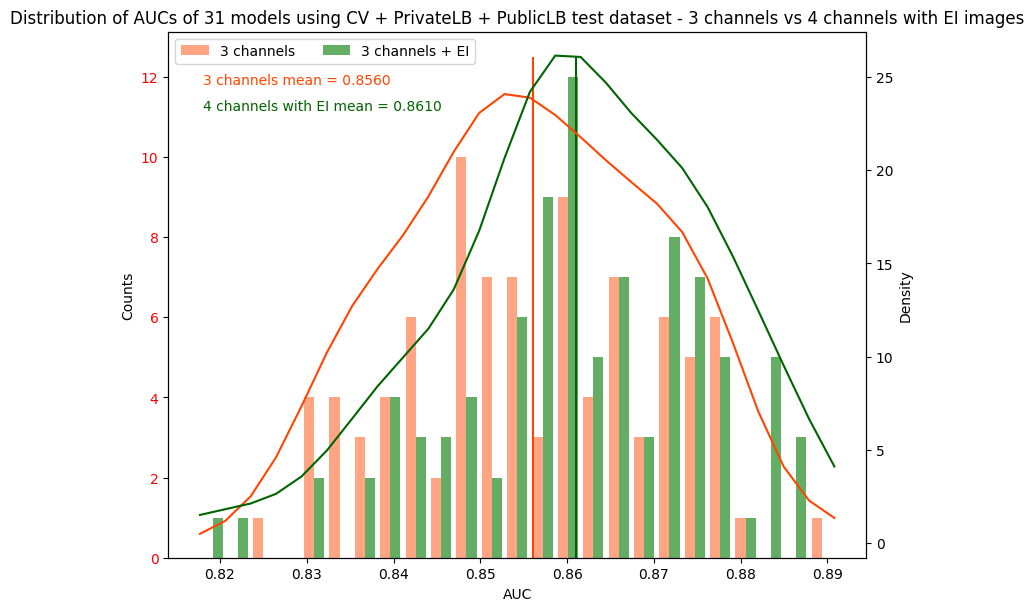

4 channels with EI vs 3 channeles t-statistic = -2.32, p value = 0.0216
Reject the null hypothesis.



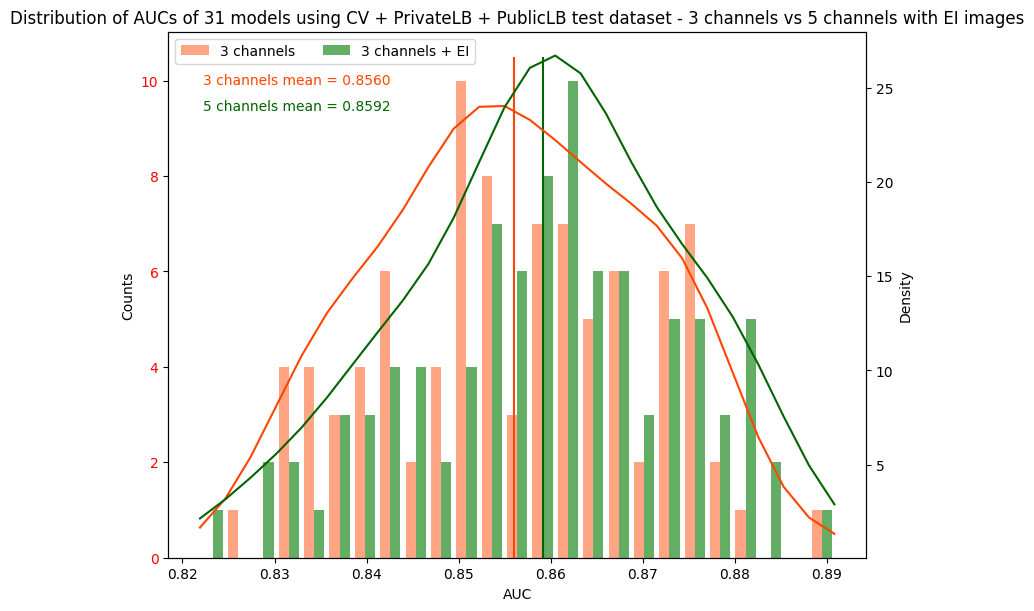

5 channels vs 3 channeles t-statistic = -1.49, p value = 0.1384
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6532.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




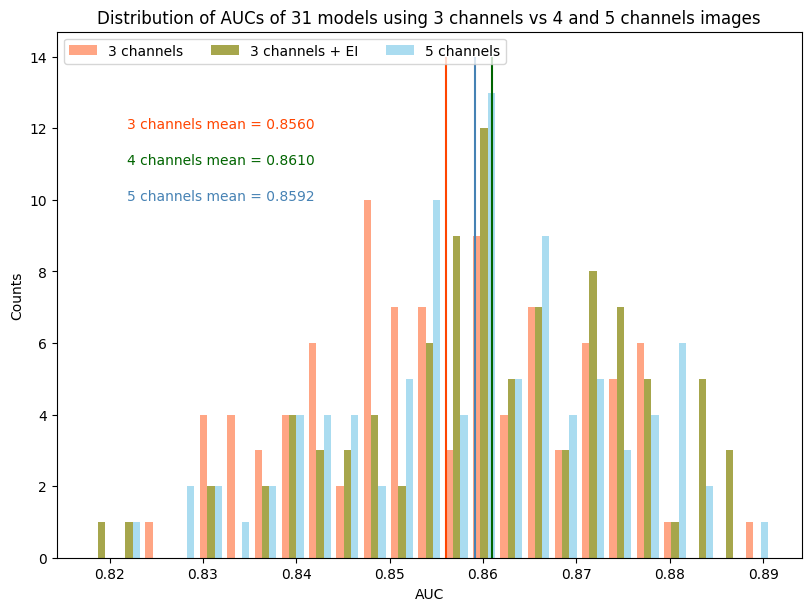

In [33]:
plot(models_res_EI, 'EI')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for Cross-Validation (CV) dataset only: 17
Degrees of freedom = 32, Critical Value = 1.6939 

Degrees of freedom = 32, Critical Value = 1.6939 



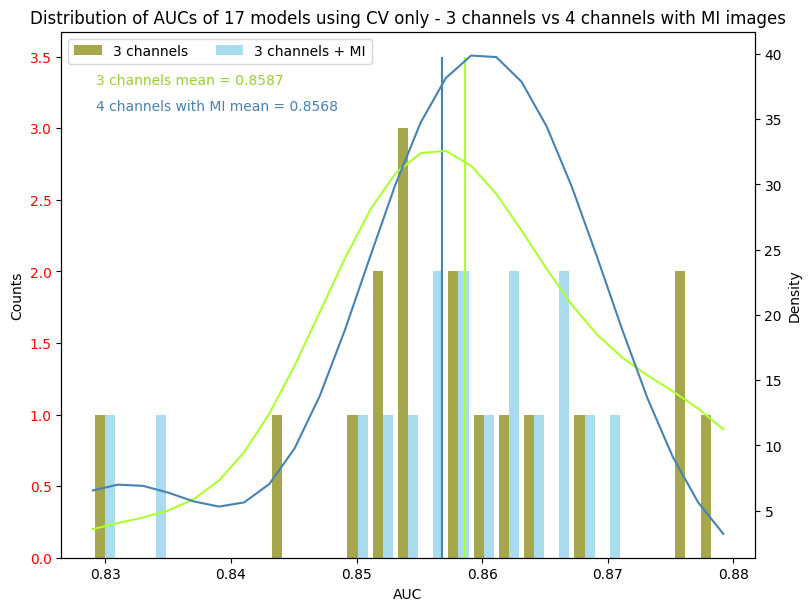

4 channels with MI vs 3 channeles t-statistic = 0.48, p value = 0.6373
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6939.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




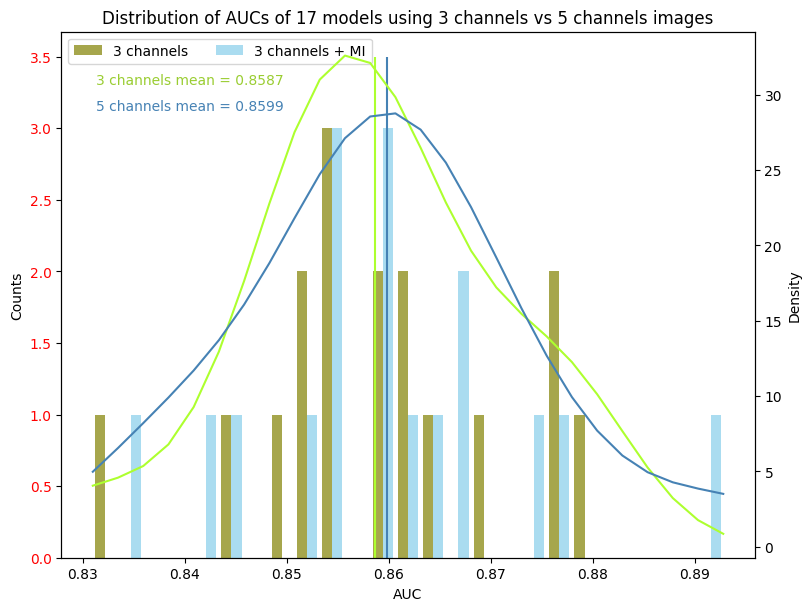

5 channels vs 3 channeles t-statistic = -0.27, p value = 0.7917
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6939.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




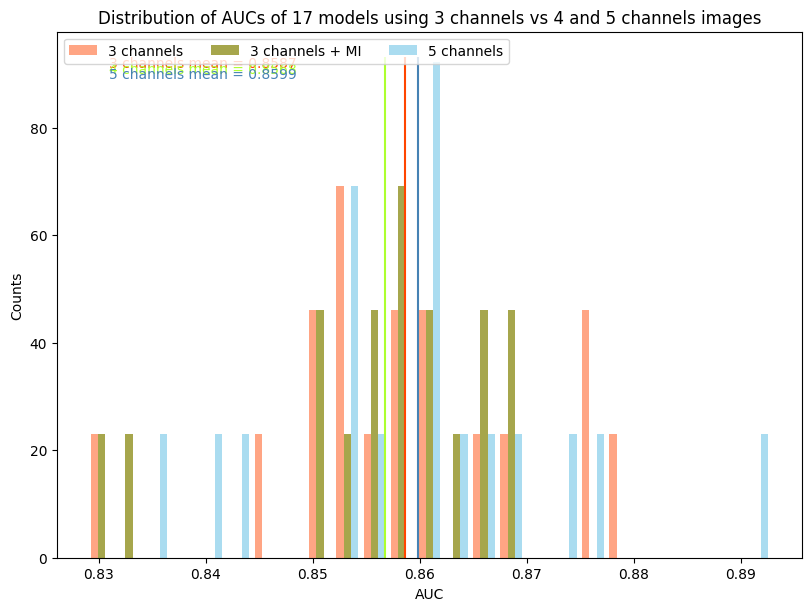

Number of the data points in the combined CV + PrivateLB + PublicLB dataset: 51
Degrees of freedom = 100, Critical Value = 1.6602 



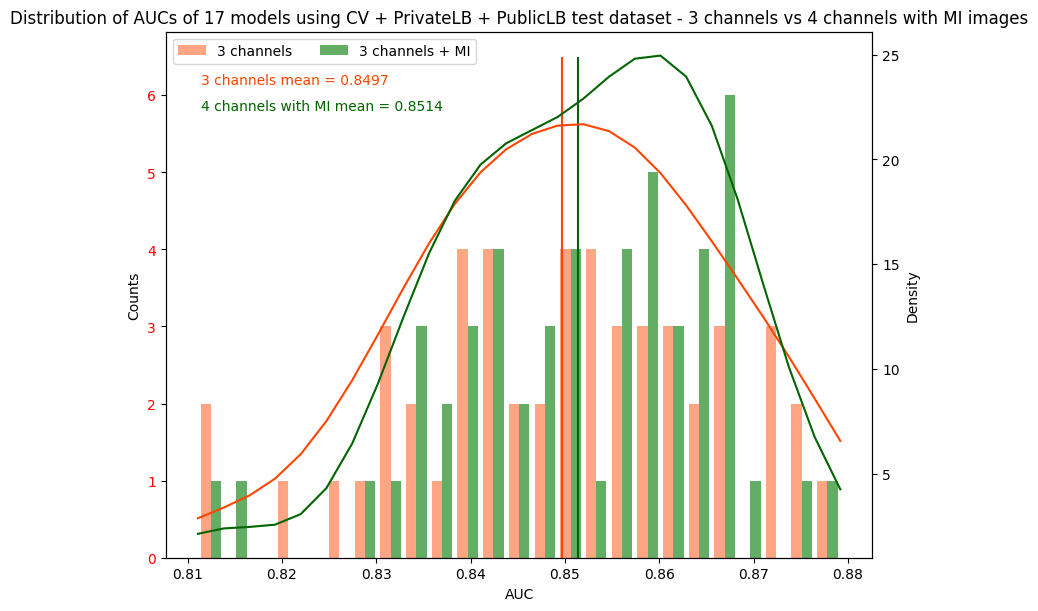

4 channels with MI vs 3 channeles t-statistic = -0.56, p value = 0.5744
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6602.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




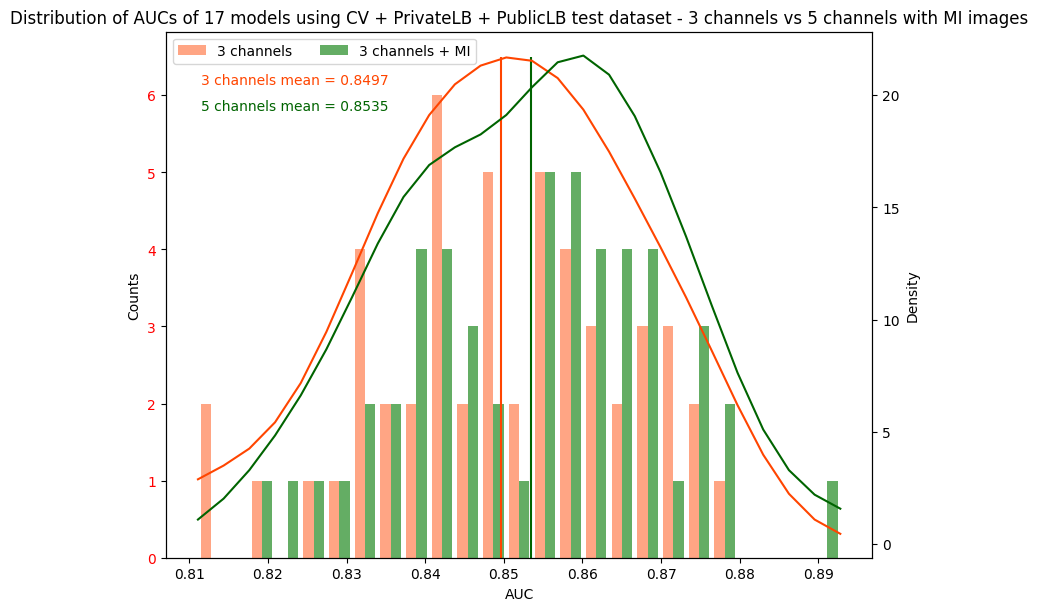

5 channels vs 3 channeles t-statistic = -1.19, p value = 0.2355
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6602.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.




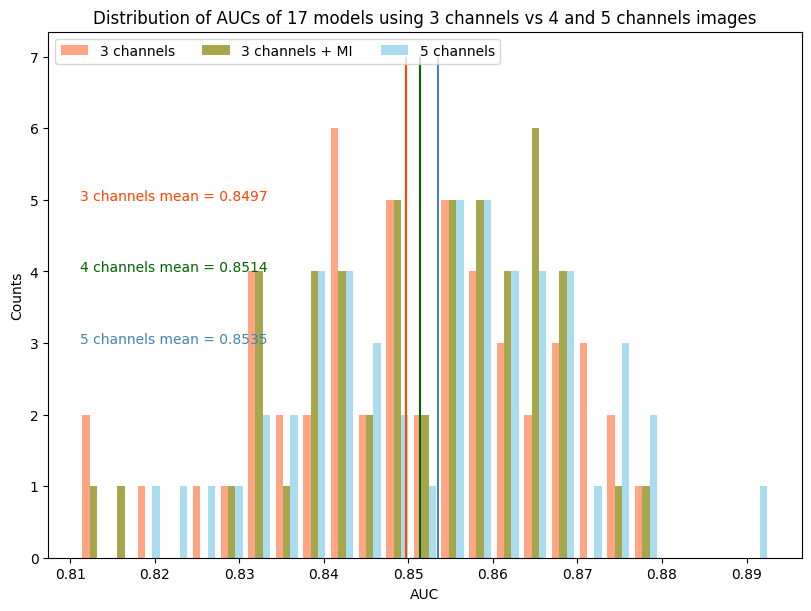

In [34]:
plot(models_res_MI, 'MI')

In [19]:
t_decision(models_res_EI, 'EI')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for Cross-Validation (CV) dataset only: 31
Means:
3 channels: 0.8666
4 channels with EI: 0.8715
4 channels with MI: 0.8599
5 channels: 0.8679
The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
LeveneResult(statistic=2.8029163319431123, pvalue=0.06565550685953281)
Degrees of freedom = 60, Critical Value = 1.6706 

Levene test p-value = 0.5951677888964333, the variance is diffrent in these datasets
4 channels with EI vs 3 channeles t-statistic = -1.99, p value = 0.0516
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.


Levene test p-value = 0.027518326200731545, the variance is similar in these datasets
LeveneResult(statistic=4.941787987619831, pvalue=0.029698342055309142)
5 channels vs 3 channeles t-statistic = -0.47, p value = 0.6381
Accept the null hypothesis, because the absolute value of t-statistics is smaller than

In [20]:
t_decision(models_res_MI, 'MI')

Null hypothesis is that the means are indistinguishable. 

Number of the data points for Cross-Validation (CV) dataset only: 17
Means:
3 channels: 0.8587
4 channels with EI: 0.8640
4 channels with MI: 0.8568
5 channels: 0.8679
The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
LeveneResult(statistic=0.5742696519415951, pvalue=0.5660825745292282)
Degrees of freedom = 32, Critical Value = 1.6939 

Levene test p-value = 0.641411793675447, the variance is diffrent in these datasets
4 channels with MI vs 3 channeles t-statistic = 0.48, p value = 0.6373
Levene test = LeveneResult(statistic=0.22107377862717956, pvalue=0.641411793675447)
Accept the null hypothesis, because the absolute value of t-statistics is smaller than the critical value 1.6939.
Accept the null hypothesis, because p value is bigger than the alpha = 0.05.


Levene test p-value = 0.39960124472448666, the variance is diffrent in these datasets
LeveneResult(statistic=0.6

In [21]:
# decision(models_res)

Previous attempt (230701):

Null hypothesis is that the means are equal. 

Number of data points for Cross-Validation (CV) only: 25
Degrees of freedom = 48, Critical Value = 1.6772241953450393
4 channels vs 3 channeles t-statistic = -1.43, p value = 0.1581
Accept null hypothesis, because t-statistics is bigger than the critical value.
Accept null hypothesis, because p value is bigger than the alpha = 0.05.


5 channels vs 3 channeles t-statistic = -1.48, p value = 0.1459
Accept null hypothesis, because t-statistics is bigger than the critical value.
Accept null hypothesis, because p value is bigger than the alpha = 0.05.


Number of data points for CV + PrivateLB + Public LB: 75
Degrees of freedom = 148, Critical Value = 1.6552145061759864
4 channels vs 3 channeles t-statistic = -2.04, p value = 0.0428
Reject the null hypothesis.


5 channels vs 3 channeles t-statistic = -1.89, p value = 0.0606
Accept null hypothesis, because p value is bigger than the alpha = 0.05.

Previous attempt (230629):

Null hypothesis is that the means are equal. 

Number of data points for Cross-Validation (CV) only: 23
Degrees of freedom = 44, Critical Value = 1.6802299753652514
4 channels vs 3 channeles t-statistic = -1.24, p value = 0.2224
Accept null hypothesis, because t-statistics is bigger than the critical value.
Accept null hypothesis, because p value is bigger than the alpha = 0.05.

5 channels vs 3 channeles t-statistic = -1.47, p value = 0.1493
Accept null hypothesis, because t-statistics is bigger than the critical value.
Accept null hypothesis, because p value is bigger than the alpha = 0.05.

Number of data points for CV + PrivateLB + Public LB: 69
Degrees of freedom = 136, Critical Value = 1.6561349882437961
4 channels vs 3 channeles t-statistic = -1.90, p value = 0.0593
Accept null hypothesis, because p value is bigger than the alpha = 0.05.

5 channels vs 3 channeles t-statistic = -1.79, p value = 0.0750
Accept null hypothesis, because p value is bigger than the alpha = 0.05.
Lets test now only the results of the models which used EI index at the 4th channel.

Lets test now only the results of the models which used EI index at the 4th channel.

In [22]:
# decision(models_res_EI)

Previous attempt (230629):

Null hypothesis is that the means are equal. 

Number of data points for Cross-Validation (CV) only: 18
Degrees of freedom = 34, Critical Value = 1.6909242507706543
4 channels vs 3 channeles t-statistic = -3.05, p value = 0.0044
Reject the null hypothesis.

5 channels vs 3 channeles t-statistic = -2.22, p value = 0.0333
Reject the null hypothesis.

Number of data points for CV + PrivateLB + Public LB: 54
Degrees of freedom = 106, Critical Value = 1.6593560339325577
4 channels vs 3 channeles t-statistic = -2.69, p value = 0.0082
Reject the null hypothesis.

5 channels vs 3 channeles t-statistic = -1.61, p value = 0.1099
Accept null hypothesis, because t-statistics is bigger than the critical value.
Accept null hypothesis, because p value is bigger than the alpha = 0.05.

Lets check homogeneity of variances of the subsets

In [23]:
# print(stats.levene(CV_scores_3, CV_scores_4, center = 'mean'))
# print(stats.levene(CV_scores_3, CV_scores_5, center = 'mean'))

The test is not significant which indicates the groups have similar amount of variation

In [24]:
#create 95% confidence interval for current set of models mean AUC gain
ci_CV5 = st.t.interval(confidence=0.95, df=len(CV5_channels)-1, loc=np.mean(CV5_channels), scale=st.sem(CV5_channels)) 
print(f'Mean of AUC gain in cross-validation 5ch vs 3ch is {np.mean(CV5_channels) * 100:.2f}%. 95% Confidence interval is ({ci_CV5[0] * 100:.2f}%, {ci_CV5[1] * 100:.2f}%)')
ci_CV4 = st.t.interval(confidence=0.95, df=len(CV4_channels)-1, loc=np.mean(CV4_channels), scale=st.sem(CV4_channels)) 
print(f'Mean of AUC gain in cross-validation 4ch vs 3ch is {np.mean(CV4_channels) * 100:.2f}%. 95% Confidence interval is ({ci_CV4[0] * 100:.2f}%, {ci_CV4[1] * 100:.2f}%)\n')

ci_Pub5 = st.t.interval(confidence=0.95, df=len(Pub5_channels)-1, loc=np.mean(Pub5_channels), scale=st.sem(Pub5_channels)) 
print(f'Mean of AUC gain in validation on Kaggle Public test set 5ch vs 3ch is {np.mean(Pub5_channels) * 100:.2f}%. 95% Confidence interval is ({ci_Pub5[0] * 100:.2f}%, {ci_Pub5[1] * 100:.2f}%)')
ci_Pub4 = st.t.interval(confidence=0.95, df=len(Pub4_channels)-1, loc=np.mean(Pub4_channels), scale=st.sem(Pub4_channels)) 
print(f'Mean of AUC gain in validation on Kaggle Public test set  4ch vs 3ch is {np.mean(Pub4_channels) * 100:.2f}%. 95% Confidence interval is ({ci_Pub4[0] * 100:.2f}%, {ci_Pub4[1] * 100:.2f}%)\n')

ci_Prv5 = st.t.interval(confidence=0.95, df=len(Prv5_channels)-1, loc=np.mean(Prv5_channels), scale=st.sem(Prv5_channels)) 
print(f'Mean of AUC gain in validation on Kaggle Private test set n 5ch vs 3ch is {np.mean(Prv5_channels) * 100:.2f}%. 95% Confidence interval is ({ci_Prv5[0] * 100:.2f}%, {ci_Prv5[1] * 100:.2f}%)')
ci_Prv4 = st.t.interval(confidence=0.95, df=len(Prv4_channels)-1, loc=np.mean(Prv4_channels), scale=st.sem(Prv4_channels)) 
print(f'Mean of AUC gain in validation on Kaggle Private test set  4ch vs 3ch is {np.mean(Prv4_channels) * 100:.2f}%. 95% Confidence interval is ({ci_Prv4[0] * 100:.2f}%, {ci_Prv4[1] * 100:.2f}%)\n')

all_5 = np.concatenate((CV5_channels, Pub5_channels, Prv5_channels))
ci_all5 = st.t.interval(confidence=0.95, df=len(all_5)-1, loc=np.mean(all_5), scale=st.sem(all_5)) 
print(f'Mean of AUC gain in validation on all of 3 test sets 5ch vs 3ch is {np.mean(all_5) * 100:.2f}%. 95% Confidence interval is ({ci_all5[0] * 100:.2f}%, {ci_all5[1] * 100:.2f}%)')
ci_all5_norm = st.norm.interval(confidence=0.95, loc=np.mean(all_5), scale=st.sem(all_5))
print(f'Mean of AUC gain in validation on all of 3 test sets 5ch vs 3ch is {np.mean(all_5) * 100:.2f}%. 95% Confidence interval norm is ({ci_all5_norm[0] * 100:.2f}%, {ci_all5_norm[1] * 100:.2f}%)\n')

all_4 = np.concatenate((CV5_channels, Pub4_channels, Prv4_channels))
ci_all4 = st.t.interval(confidence=0.95, df=len(all_4)-1, loc=np.mean(all_4), scale=st.sem(all_4)) 
print(f'Mean of AUC gain in validation on all of 3 test sets 4ch vs 3ch is {np.mean(all_4) * 100:.2f}%. 95% Confidence interval is ({ci_all4[0] * 100:.2f}%, {ci_all4[1] * 100:.2f}%)')
ci_all4_norm = st.norm.interval(confidence=0.95, loc=np.mean(all_4), scale=st.sem(all_4))
#ci_all4_norm = st.norm.interval(alpha=0.95, loc=np.mean(all_4), scale=st.sem(all_4))
print(f'Mean of AUC gain in validation on all of 3 test sets 4ch vs 3ch is {np.mean(all_4) * 100:.2f}%. 95% Confidence interval norm is ({ci_all4_norm[0] * 100:.2f}%, {ci_all4_norm[1] * 100:.2f}%)\n')


NameError: name 'CV5_channels' is not defined

In [ ]:
text = " XYZ "
formatstring = "\x1b[{}m" + text + "\x1b[m"

print(
    " " * 6
    + " " * len(text)
    + "".join("{:^{}}".format(bg, len(text)) for bg in range(40, 48))
)
for fg in range(30, 38):
    for bold in False, True:
        fg_code = ("1;" if bold else "") + str(fg)
        print(
            " {:>4} ".format(fg_code)
            + formatstring.format(fg_code)
            + "".join(
                formatstring.format(fg_code + ";" + str(bg)) for bg in range(40, 48)
            )
        )

In [ ]:
        print(
            " {:>4} ".format(fg_code)
            + formatstring.format(fg_code)
            + "".join(
                formatstring.format(fg_code + ";" + str(bg)) for bg in range(40, 41)
            ))

In [ ]:
" {:>4} ".format(fg_code)+ formatstring.format(fg_code)+ "".join(formatstring.format(fg_code + ";" + str(bg)) for bg in range(40, 41))

In [ ]:
formatstring

In [ ]:
print(formatstring.format('31'))

In [ ]:
print(fg_code" {:>4} ".format(fg_code)+formatstring.format(fg_code)+"".join(formatstring.format(fg_code + ";" + str(bg)) for bg in range(40, 41))))

In [ ]:
" {:>4} ".format(fg_code)+formatstring.format(fg_code)+"".join(formatstring.format(fg_code + ";" + str(bg)) for bg in range(40, 41))